In [12]:
# Imports
import torch
import torch.nn as nn  # All neural network modules 
import torch.nn.init as init    # For weight initializations
import torch.optim as optim  # For all optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a clear way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from tqdm import tqdm # For progress bars 
import matplotlib.pyplot as plt # For graphing  
import numpy as np  # For graphing  
import pandas as pd     # For data frames
import seaborn as sns   # For graphing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


In [13]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 12000
num_epoches = 5

In [14]:
# Get MNIST data
train_ds = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)

test_ds = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

# Print the number of images in the training set
print("Number of training images:", len(train_ds))

# Print the number of images in the test set
print("Number of test images:", len(test_ds))


Number of training images: 60000
Number of test images: 10000


In [15]:
class OverallNet(nn.Module):
  def __init__(self, num_dendritic_inputs, num_neurons, num_dendrite_neuron_layers):
    super().__init__()
    # Input: 28 by 28 pixel image = 784 artifical neurons
    # Output: Digit from zero to nine
    
    if num_dendrite_neuron_layers == 1:
      self.layer1 = nn.Linear(784, num_dendritic_inputs)
      self.layer2 = nn.Linear(num_dendritic_inputs, num_neurons)
      self.layer3 = nn.Linear(num_neurons, 10)

      # Apply He weight initialization
      init.kaiming_uniform_(self.layer1.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer2.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer3.weight, mode="fan_in", nonlinearity="relu")

    elif num_dendrite_neuron_layers == 2:
      self.layer1 = nn.Linear(784, num_dendritic_inputs)
      self.layer2 = nn.Linear(num_dendritic_inputs, num_neurons)
      self.layer3 = nn.Linear(num_neurons, num_dendritic_inputs)
      self.layer4 = nn.Linear(num_dendritic_inputs, num_neurons)
      self.layer5 = nn.Linear(num_neurons, 10)

    # Apply He weight initialization
      init.kaiming_uniform_(self.layer1.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer2.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer3.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer4.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer5.weight, mode="fan_in", nonlinearity="relu")

    self.R = nn.ReLU()

  def forward(self, x, num_neurons, chunk_size, num_dendrite_neuron_layers):
    x = x.view(-1,28**2)
    x = self.R(self.layer1(x))

    # Debug only: 
    # print(x.size())
    # print(self.layer2.bias.size())

    somas_1 = []
  
    # Iterate through all output neurons to get their individual feedforward result
    # Layer 2 to 3 dendrites to somas
    for i in range(num_neurons):
      chunk_neuron_input = x[:, (chunk_size * i):(chunk_size * i + chunk_size)]   # Divide chunk of converging inputs by 8
      layer2_weights = nn.Parameter(self.layer2.weight[i, (chunk_size * i):(chunk_size * i + chunk_size)].unsqueeze(0))   # Divide chunk of converging weights by 16
      layer2_bias = nn.Parameter(self.layer2.bias[i]) # Set bias for the nueron of interest
  
      # Debug only: 
      # print(chunk_neuron_input.size())
      # print(layer2_weights.size())
      # print(layer2_bias.size())
      
      neuron_forward = self.R(torch.mm(chunk_neuron_input, layer2_weights.t()) + layer2_bias)
      
      somas_1.append(neuron_forward)
      
      # Debug only: 
      # print(somas)

    x = torch.cat(somas_1, dim=1) # concatenate the resulting matrices of layer 2
    x = self.R(self.layer3(x))

    # Debug only: 
    # print(x.size())
    # print(self.layer4.weight.size())
    # print(self.layer5.bias.size())
    # print(self.layer5.bias)

    if num_dendrite_neuron_layers == 2:
      somas_2 = []

      # Layer 4 to 5 dendrites to somas
      for i in range(num_neurons):
          # print(i)
          chunk_neuron_input = x[:, (chunk_size * i):(chunk_size * i + chunk_size)]   # Divide chunk of converging inputs by 8
          layer4_weights = nn.Parameter(self.layer4.weight[i, (chunk_size * i):(chunk_size * i + chunk_size)].unsqueeze(0))   # Divide chunk of converging weights by 16
          layer4_bias = nn.Parameter(self.layer4.bias[i]) # Set bias for the nueron of interest
      
          # Debug only: 
          # print(layer5_bias)
          # print(chunk_neuron_input.size())
          # print(layer4_weights.size())
          # print(layer5_bias.size())
          
          neuron_forward = self.R(torch.mm(chunk_neuron_input, layer4_weights.t()) + layer4_bias)
          
          somas_2.append(neuron_forward)
          
          # Debug only: 
          # print(somas)

      x = torch.cat(somas_2, dim=1) # concatenate the resulting matrices of layer 4

      x = self.R(self.layer5(x))
    
    return x

In [16]:
# Check parameter matrix sizes
def print_parameter_info(model):
    for name, param in model.named_parameters():
        print(name)
        print(type(param), param.size())

In [17]:
def freeze_network_layers(model):
  # Freeze weights and biases
  for name, param in model.named_parameters():
    # Freeze layer 1's weights and biases if set to False
    if param.requires_grad and 'layer1' in name:
        param.requires_grad = True
    # Freeze layer 2's weights and biases
    elif param.requires_grad and 'layer2' in name: 
        param.requires_grad = False               
    # # Freeze layer 3's weights and biases if set to False
    # elif param.requires_grad and 'layer3' in name:
    #     param.requires_grad = True
    # # Freeze layer 4's weights and biases 
    # elif param.requires_grad and 'layer4' in name:
    #     # Freeze layer 4's weights and biases if set to False
    #     param.requires_grad = True

In [18]:
# Train Network
def train_network(device, num_epoches, train_loader, model, criterion, optimizer, num_neurons, chunk_size, num_dendrite_neuron_layers):
    for epoch in range(num_epoches):
        losses = []

        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data, num_neurons, chunk_size, num_dendrite_neuron_layers)
            loss = criterion(scores, targets)

            losses.append(loss.item())
            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        # print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")


In [19]:
def check_accuracy(loader, model, num_neurons, chunk_size, num_dendrite_neuron_layers):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x, num_neurons, chunk_size, num_dendrite_neuron_layers)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        accuracy = float(num_correct)/float(num_samples)
        print(f"Got {num_correct} / {num_samples} with accuracy {accuracy*100:.2f}%")

    # Set the model mode to train
    model.train()
    return accuracy

In [20]:
def run_trials(num_dendritic_inputs, num_neurons, num_dendrite_neuron_layers, num_trainings):
  acc_dict = {}
  acc_dict[0] = 0

  chunk_size = num_dendritic_inputs // num_neurons
  model = OverallNet(num_dendritic_inputs, num_neurons, num_dendrite_neuron_layers)
  freeze_network_layers(model)
  print_parameter_info(model) 
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
  for training in range(num_trainings):
    train_network(device, num_epoches, train_loader, model, criterion, optimizer, num_neurons, chunk_size, num_dendrite_neuron_layers)
    
    acc_dict[training + 1] = check_accuracy(test_loader, model, num_neurons, chunk_size, num_dendrite_neuron_layers)
    print(f"Row: {training + 1} | {num_dendritic_inputs} | {num_neurons} | {list(acc_dict.values())}")

  # Plot graph of accuracies after the trial
  ypoints = np.array(list(acc_dict.values()))
  plt.xticks(np.arange(0, len(ypoints), 1.0))
  plt.xlabel("Number of trainings")
  plt.ylabel("Accuracy")
  plt.title(f"{num_dendrite_neuron_layers} layers of {num_dendritic_inputs} dendrites and {num_neurons} neurons")
  plt.plot(ypoints)
  plt.show()

  return list(acc_dict.values())

--- NEW MODEL 0 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Checking accuracy on test data
Got 6054 / 10000 with accuracy 60.54%
Row: 1 | 392 | 14 | [0, 0.6054]


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Checking accuracy on test data
Got 7116 / 10000 with accuracy 71.16%
Row: 2 | 392 | 14 | [0, 0.6054, 0.7116]


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Checking accuracy on test data
Got 7333 / 10000 with accuracy 73.33%
Row: 3 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333]


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Checking accuracy on test data
Got 7677 / 10000 with accuracy 76.77%
Row: 4 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677]


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Checking accuracy on test data
Got 7879 / 10000 with accuracy 78.79%
Row: 5 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879]


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Checking accuracy on test data
Got 7996 / 10000 with accuracy 79.96%
Row: 6 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996]


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Checking accuracy on test data
Got 8084 / 10000 with accuracy 80.84%
Row: 7 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996, 0.8084]


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Checking accuracy on test data
Got 8158 / 10000 with accuracy 81.58%
Row: 8 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996, 0.8084, 0.8158]


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Checking accuracy on test data
Got 8217 / 10000 with accuracy 82.17%
Row: 9 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996, 0.8084, 0.8158, 0.8217]


100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


Checking accuracy on test data
Got 8260 / 10000 with accuracy 82.60%
Row: 10 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996, 0.8084, 0.8158, 0.8217, 0.826]


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Checking accuracy on test data
Got 8308 / 10000 with accuracy 83.08%
Row: 11 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996, 0.8084, 0.8158, 0.8217, 0.826, 0.8308]


100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


Checking accuracy on test data
Got 8335 / 10000 with accuracy 83.35%
Row: 12 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996, 0.8084, 0.8158, 0.8217, 0.826, 0.8308, 0.8335]


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Checking accuracy on test data
Got 8357 / 10000 with accuracy 83.57%
Row: 13 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996, 0.8084, 0.8158, 0.8217, 0.826, 0.8308, 0.8335, 0.8357]


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Checking accuracy on test data
Got 8382 / 10000 with accuracy 83.82%
Row: 14 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996, 0.8084, 0.8158, 0.8217, 0.826, 0.8308, 0.8335, 0.8357, 0.8382]


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Checking accuracy on test data
Got 8407 / 10000 with accuracy 84.07%
Row: 15 | 392 | 14 | [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996, 0.8084, 0.8158, 0.8217, 0.826, 0.8308, 0.8335, 0.8357, 0.8382, 0.8407]


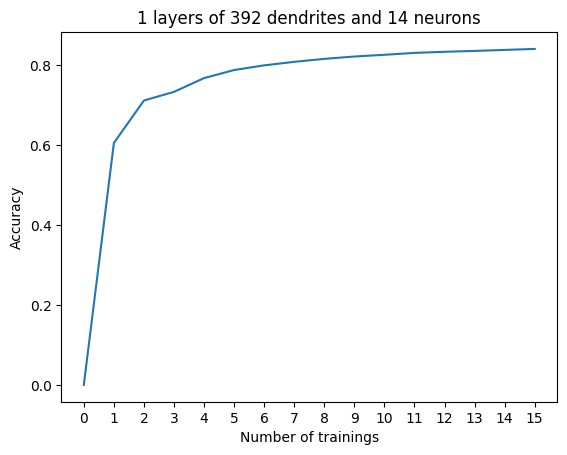

--- NEW MODEL 1 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Checking accuracy on test data
Got 5540 / 10000 with accuracy 55.40%
Row: 1 | 392 | 14 | [0, 0.554]


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


Checking accuracy on test data
Got 6490 / 10000 with accuracy 64.90%
Row: 2 | 392 | 14 | [0, 0.554, 0.649]


100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


Checking accuracy on test data
Got 6592 / 10000 with accuracy 65.92%
Row: 3 | 392 | 14 | [0, 0.554, 0.649, 0.6592]


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


Checking accuracy on test data
Got 7459 / 10000 with accuracy 74.59%
Row: 4 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459]


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


Checking accuracy on test data
Got 7523 / 10000 with accuracy 75.23%
Row: 5 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523]


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


Checking accuracy on test data
Got 7553 / 10000 with accuracy 75.53%
Row: 6 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 7575 / 10000 with accuracy 75.75%
Row: 7 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553, 0.7575]


100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Checking accuracy on test data
Got 7603 / 10000 with accuracy 76.03%
Row: 8 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553, 0.7575, 0.7603]


100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Checking accuracy on test data
Got 8396 / 10000 with accuracy 83.96%
Row: 9 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553, 0.7575, 0.7603, 0.8396]


100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


Checking accuracy on test data
Got 8503 / 10000 with accuracy 85.03%
Row: 10 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553, 0.7575, 0.7603, 0.8396, 0.8503]


100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


Checking accuracy on test data
Got 8534 / 10000 with accuracy 85.34%
Row: 11 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553, 0.7575, 0.7603, 0.8396, 0.8503, 0.8534]


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


Checking accuracy on test data
Got 8546 / 10000 with accuracy 85.46%
Row: 12 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553, 0.7575, 0.7603, 0.8396, 0.8503, 0.8534, 0.8546]


100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


Checking accuracy on test data
Got 8563 / 10000 with accuracy 85.63%
Row: 13 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553, 0.7575, 0.7603, 0.8396, 0.8503, 0.8534, 0.8546, 0.8563]


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


Checking accuracy on test data
Got 8579 / 10000 with accuracy 85.79%
Row: 14 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553, 0.7575, 0.7603, 0.8396, 0.8503, 0.8534, 0.8546, 0.8563, 0.8579]


100%|██████████| 5/5 [00:16<00:00,  3.40s/it]


Checking accuracy on test data
Got 8600 / 10000 with accuracy 86.00%
Row: 15 | 392 | 14 | [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553, 0.7575, 0.7603, 0.8396, 0.8503, 0.8534, 0.8546, 0.8563, 0.8579, 0.86]


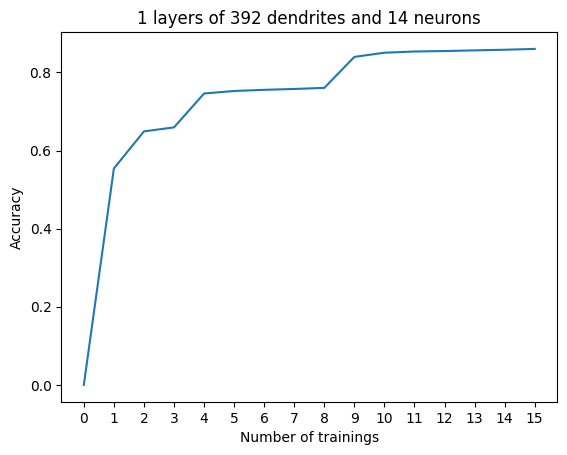

--- NEW MODEL 2 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:16<00:00,  3.40s/it]


Checking accuracy on test data
Got 6241 / 10000 with accuracy 62.41%
Row: 1 | 392 | 14 | [0, 0.6241]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 7667 / 10000 with accuracy 76.67%
Row: 2 | 392 | 14 | [0, 0.6241, 0.7667]


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


Checking accuracy on test data
Got 8743 / 10000 with accuracy 87.43%
Row: 3 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743]


100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


Checking accuracy on test data
Got 8965 / 10000 with accuracy 89.65%
Row: 4 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965]


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Checking accuracy on test data
Got 9085 / 10000 with accuracy 90.85%
Row: 5 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085]


100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


Checking accuracy on test data
Got 9158 / 10000 with accuracy 91.58%
Row: 6 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158]


100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Checking accuracy on test data
Got 9214 / 10000 with accuracy 92.14%
Row: 7 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158, 0.9214]


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


Checking accuracy on test data
Got 9257 / 10000 with accuracy 92.57%
Row: 8 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158, 0.9214, 0.9257]


100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


Checking accuracy on test data
Got 9300 / 10000 with accuracy 93.00%
Row: 9 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158, 0.9214, 0.9257, 0.93]


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


Checking accuracy on test data
Got 9324 / 10000 with accuracy 93.24%
Row: 10 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158, 0.9214, 0.9257, 0.93, 0.9324]


100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


Checking accuracy on test data
Got 9349 / 10000 with accuracy 93.49%
Row: 11 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158, 0.9214, 0.9257, 0.93, 0.9324, 0.9349]


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


Checking accuracy on test data
Got 9373 / 10000 with accuracy 93.73%
Row: 12 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158, 0.9214, 0.9257, 0.93, 0.9324, 0.9349, 0.9373]


100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


Checking accuracy on test data
Got 9384 / 10000 with accuracy 93.84%
Row: 13 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158, 0.9214, 0.9257, 0.93, 0.9324, 0.9349, 0.9373, 0.9384]


100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


Checking accuracy on test data
Got 9414 / 10000 with accuracy 94.14%
Row: 14 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158, 0.9214, 0.9257, 0.93, 0.9324, 0.9349, 0.9373, 0.9384, 0.9414]


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


Checking accuracy on test data
Got 9428 / 10000 with accuracy 94.28%
Row: 15 | 392 | 14 | [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158, 0.9214, 0.9257, 0.93, 0.9324, 0.9349, 0.9373, 0.9384, 0.9414, 0.9428]


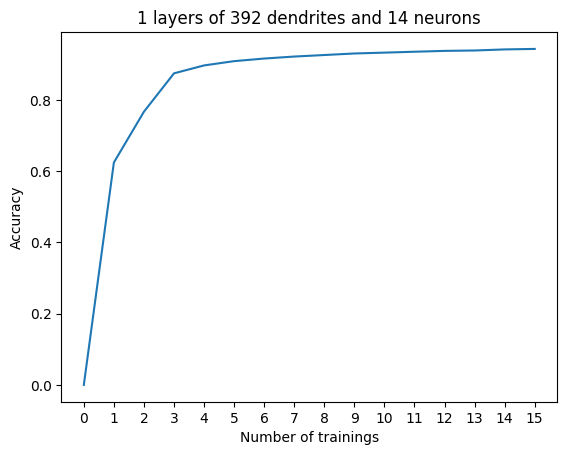

--- NEW MODEL 3 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


Checking accuracy on test data
Got 5968 / 10000 with accuracy 59.68%
Row: 1 | 392 | 14 | [0, 0.5968]


100%|██████████| 5/5 [00:17<00:00,  3.41s/it]


Checking accuracy on test data
Got 6947 / 10000 with accuracy 69.47%
Row: 2 | 392 | 14 | [0, 0.5968, 0.6947]


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


Checking accuracy on test data
Got 7326 / 10000 with accuracy 73.26%
Row: 3 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326]


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


Checking accuracy on test data
Got 7453 / 10000 with accuracy 74.53%
Row: 4 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453]


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Checking accuracy on test data
Got 7520 / 10000 with accuracy 75.20%
Row: 5 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752]


100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


Checking accuracy on test data
Got 7566 / 10000 with accuracy 75.66%
Row: 6 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566]


100%|██████████| 5/5 [00:17<00:00,  3.41s/it]


Checking accuracy on test data
Got 7607 / 10000 with accuracy 76.07%
Row: 7 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566, 0.7607]


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


Checking accuracy on test data
Got 7630 / 10000 with accuracy 76.30%
Row: 8 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566, 0.7607, 0.763]


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


Checking accuracy on test data
Got 7659 / 10000 with accuracy 76.59%
Row: 9 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566, 0.7607, 0.763, 0.7659]


100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


Checking accuracy on test data
Got 7673 / 10000 with accuracy 76.73%
Row: 10 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566, 0.7607, 0.763, 0.7659, 0.7673]


100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


Checking accuracy on test data
Got 7684 / 10000 with accuracy 76.84%
Row: 11 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566, 0.7607, 0.763, 0.7659, 0.7673, 0.7684]


100%|██████████| 5/5 [00:16<00:00,  3.31s/it]


Checking accuracy on test data
Got 7694 / 10000 with accuracy 76.94%
Row: 12 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566, 0.7607, 0.763, 0.7659, 0.7673, 0.7684, 0.7694]


100%|██████████| 5/5 [00:16<00:00,  3.31s/it]


Checking accuracy on test data
Got 7714 / 10000 with accuracy 77.14%
Row: 13 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566, 0.7607, 0.763, 0.7659, 0.7673, 0.7684, 0.7694, 0.7714]


100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


Checking accuracy on test data
Got 8499 / 10000 with accuracy 84.99%
Row: 14 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566, 0.7607, 0.763, 0.7659, 0.7673, 0.7684, 0.7694, 0.7714, 0.8499]


100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


Checking accuracy on test data
Got 8615 / 10000 with accuracy 86.15%
Row: 15 | 392 | 14 | [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566, 0.7607, 0.763, 0.7659, 0.7673, 0.7684, 0.7694, 0.7714, 0.8499, 0.8615]


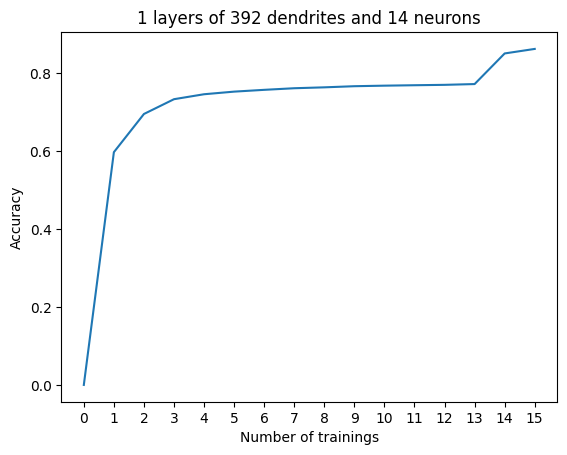

--- NEW MODEL 4 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


Checking accuracy on test data
Got 5685 / 10000 with accuracy 56.85%
Row: 1 | 392 | 14 | [0, 0.5685]


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


Checking accuracy on test data
Got 7306 / 10000 with accuracy 73.06%
Row: 2 | 392 | 14 | [0, 0.5685, 0.7306]


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


Checking accuracy on test data
Got 8060 / 10000 with accuracy 80.60%
Row: 3 | 392 | 14 | [0, 0.5685, 0.7306, 0.806]


100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


Checking accuracy on test data
Got 8202 / 10000 with accuracy 82.02%
Row: 4 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202]


100%|██████████| 5/5 [00:16<00:00,  3.31s/it]


Checking accuracy on test data
Got 8288 / 10000 with accuracy 82.88%
Row: 5 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288]


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


Checking accuracy on test data
Got 8346 / 10000 with accuracy 83.46%
Row: 6 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346]


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


Checking accuracy on test data
Got 8395 / 10000 with accuracy 83.95%
Row: 7 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346, 0.8395]


100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Checking accuracy on test data
Got 8433 / 10000 with accuracy 84.33%
Row: 8 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346, 0.8395, 0.8433]


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Checking accuracy on test data
Got 8453 / 10000 with accuracy 84.53%
Row: 9 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346, 0.8395, 0.8433, 0.8453]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 8469 / 10000 with accuracy 84.69%
Row: 10 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346, 0.8395, 0.8433, 0.8453, 0.8469]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 8485 / 10000 with accuracy 84.85%
Row: 11 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346, 0.8395, 0.8433, 0.8453, 0.8469, 0.8485]


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Checking accuracy on test data
Got 8505 / 10000 with accuracy 85.05%
Row: 12 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346, 0.8395, 0.8433, 0.8453, 0.8469, 0.8485, 0.8505]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 8514 / 10000 with accuracy 85.14%
Row: 13 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346, 0.8395, 0.8433, 0.8453, 0.8469, 0.8485, 0.8505, 0.8514]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 8533 / 10000 with accuracy 85.33%
Row: 14 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346, 0.8395, 0.8433, 0.8453, 0.8469, 0.8485, 0.8505, 0.8514, 0.8533]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 8548 / 10000 with accuracy 85.48%
Row: 15 | 392 | 14 | [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346, 0.8395, 0.8433, 0.8453, 0.8469, 0.8485, 0.8505, 0.8514, 0.8533, 0.8548]


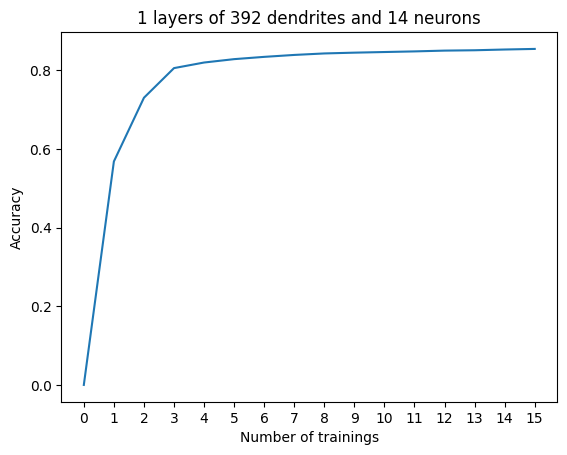

--- NEW MODEL 5 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 6329 / 10000 with accuracy 63.29%
Row: 1 | 392 | 14 | [0, 0.6329]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 7312 / 10000 with accuracy 73.12%
Row: 2 | 392 | 14 | [0, 0.6329, 0.7312]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 7491 / 10000 with accuracy 74.91%
Row: 3 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491]


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Checking accuracy on test data
Got 7571 / 10000 with accuracy 75.71%
Row: 4 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 8159 / 10000 with accuracy 81.59%
Row: 5 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159]


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Checking accuracy on test data
Got 8421 / 10000 with accuracy 84.21%
Row: 6 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 8473 / 10000 with accuracy 84.73%
Row: 7 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421, 0.8473]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 8520 / 10000 with accuracy 85.20%
Row: 8 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421, 0.8473, 0.852]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 8557 / 10000 with accuracy 85.57%
Row: 9 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421, 0.8473, 0.852, 0.8557]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 8578 / 10000 with accuracy 85.78%
Row: 10 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421, 0.8473, 0.852, 0.8557, 0.8578]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 8595 / 10000 with accuracy 85.95%
Row: 11 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421, 0.8473, 0.852, 0.8557, 0.8578, 0.8595]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 8613 / 10000 with accuracy 86.13%
Row: 12 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421, 0.8473, 0.852, 0.8557, 0.8578, 0.8595, 0.8613]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 8639 / 10000 with accuracy 86.39%
Row: 13 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421, 0.8473, 0.852, 0.8557, 0.8578, 0.8595, 0.8613, 0.8639]


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Checking accuracy on test data
Got 8654 / 10000 with accuracy 86.54%
Row: 14 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421, 0.8473, 0.852, 0.8557, 0.8578, 0.8595, 0.8613, 0.8639, 0.8654]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 8666 / 10000 with accuracy 86.66%
Row: 15 | 392 | 14 | [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421, 0.8473, 0.852, 0.8557, 0.8578, 0.8595, 0.8613, 0.8639, 0.8654, 0.8666]


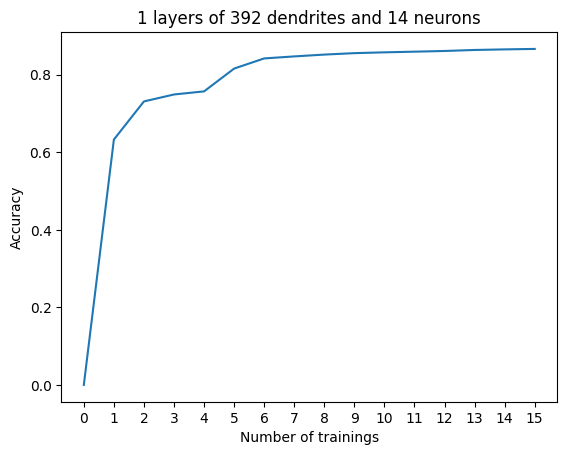

--- NEW MODEL 6 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 6095 / 10000 with accuracy 60.95%
Row: 1 | 392 | 14 | [0, 0.6095]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 7645 / 10000 with accuracy 76.45%
Row: 2 | 392 | 14 | [0, 0.6095, 0.7645]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 7950 / 10000 with accuracy 79.50%
Row: 3 | 392 | 14 | [0, 0.6095, 0.7645, 0.795]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 8124 / 10000 with accuracy 81.24%
Row: 4 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 8205 / 10000 with accuracy 82.05%
Row: 5 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 9009 / 10000 with accuracy 90.09%
Row: 6 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 9165 / 10000 with accuracy 91.65%
Row: 7 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009, 0.9165]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 9220 / 10000 with accuracy 92.20%
Row: 8 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009, 0.9165, 0.922]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 9281 / 10000 with accuracy 92.81%
Row: 9 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009, 0.9165, 0.922, 0.9281]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 9317 / 10000 with accuracy 93.17%
Row: 10 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009, 0.9165, 0.922, 0.9281, 0.9317]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 9348 / 10000 with accuracy 93.48%
Row: 11 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009, 0.9165, 0.922, 0.9281, 0.9317, 0.9348]


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Checking accuracy on test data
Got 9381 / 10000 with accuracy 93.81%
Row: 12 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009, 0.9165, 0.922, 0.9281, 0.9317, 0.9348, 0.9381]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 9402 / 10000 with accuracy 94.02%
Row: 13 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009, 0.9165, 0.922, 0.9281, 0.9317, 0.9348, 0.9381, 0.9402]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 9423 / 10000 with accuracy 94.23%
Row: 14 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009, 0.9165, 0.922, 0.9281, 0.9317, 0.9348, 0.9381, 0.9402, 0.9423]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 9442 / 10000 with accuracy 94.42%
Row: 15 | 392 | 14 | [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009, 0.9165, 0.922, 0.9281, 0.9317, 0.9348, 0.9381, 0.9402, 0.9423, 0.9442]


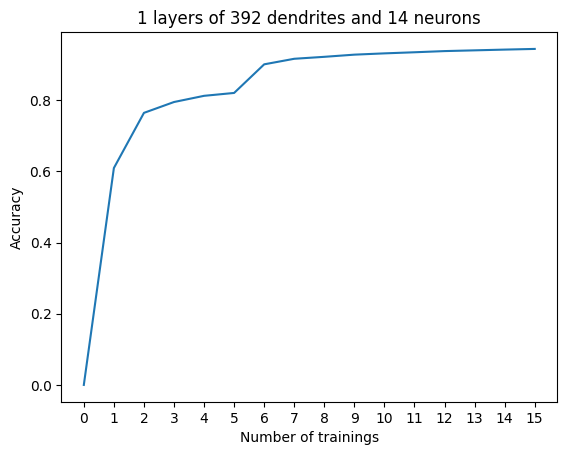

--- NEW MODEL 7 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Checking accuracy on test data
Got 6727 / 10000 with accuracy 67.27%
Row: 1 | 392 | 14 | [0, 0.6727]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 7800 / 10000 with accuracy 78.00%
Row: 2 | 392 | 14 | [0, 0.6727, 0.78]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 8074 / 10000 with accuracy 80.74%
Row: 3 | 392 | 14 | [0, 0.6727, 0.78, 0.8074]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 8222 / 10000 with accuracy 82.22%
Row: 4 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 8407 / 10000 with accuracy 84.07%
Row: 5 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 9139 / 10000 with accuracy 91.39%
Row: 6 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 9248 / 10000 with accuracy 92.48%
Row: 7 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139, 0.9248]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 9282 / 10000 with accuracy 92.82%
Row: 8 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139, 0.9248, 0.9282]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 9310 / 10000 with accuracy 93.10%
Row: 9 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139, 0.9248, 0.9282, 0.931]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 9346 / 10000 with accuracy 93.46%
Row: 10 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139, 0.9248, 0.9282, 0.931, 0.9346]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 9377 / 10000 with accuracy 93.77%
Row: 11 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139, 0.9248, 0.9282, 0.931, 0.9346, 0.9377]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 9399 / 10000 with accuracy 93.99%
Row: 12 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139, 0.9248, 0.9282, 0.931, 0.9346, 0.9377, 0.9399]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 9406 / 10000 with accuracy 94.06%
Row: 13 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139, 0.9248, 0.9282, 0.931, 0.9346, 0.9377, 0.9399, 0.9406]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 9421 / 10000 with accuracy 94.21%
Row: 14 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139, 0.9248, 0.9282, 0.931, 0.9346, 0.9377, 0.9399, 0.9406, 0.9421]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 9440 / 10000 with accuracy 94.40%
Row: 15 | 392 | 14 | [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139, 0.9248, 0.9282, 0.931, 0.9346, 0.9377, 0.9399, 0.9406, 0.9421, 0.944]


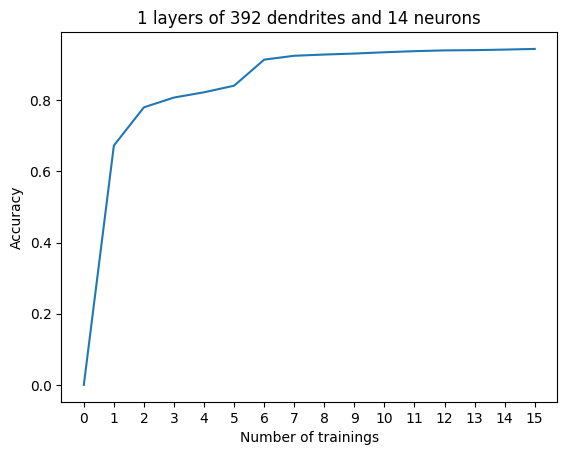

--- NEW MODEL 8 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 6049 / 10000 with accuracy 60.49%
Row: 1 | 392 | 14 | [0, 0.6049]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 6489 / 10000 with accuracy 64.89%
Row: 2 | 392 | 14 | [0, 0.6049, 0.6489]


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Checking accuracy on test data
Got 6915 / 10000 with accuracy 69.15%
Row: 3 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 7518 / 10000 with accuracy 75.18%
Row: 4 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 7789 / 10000 with accuracy 77.89%
Row: 5 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 7948 / 10000 with accuracy 79.48%
Row: 6 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789, 0.7948]


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Checking accuracy on test data
Got 8031 / 10000 with accuracy 80.31%
Row: 7 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789, 0.7948, 0.8031]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 8104 / 10000 with accuracy 81.04%
Row: 8 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789, 0.7948, 0.8031, 0.8104]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 8157 / 10000 with accuracy 81.57%
Row: 9 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789, 0.7948, 0.8031, 0.8104, 0.8157]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 8197 / 10000 with accuracy 81.97%
Row: 10 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789, 0.7948, 0.8031, 0.8104, 0.8157, 0.8197]


100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Checking accuracy on test data
Got 8256 / 10000 with accuracy 82.56%
Row: 11 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789, 0.7948, 0.8031, 0.8104, 0.8157, 0.8197, 0.8256]


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Checking accuracy on test data
Got 8282 / 10000 with accuracy 82.82%
Row: 12 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789, 0.7948, 0.8031, 0.8104, 0.8157, 0.8197, 0.8256, 0.8282]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 8315 / 10000 with accuracy 83.15%
Row: 13 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789, 0.7948, 0.8031, 0.8104, 0.8157, 0.8197, 0.8256, 0.8282, 0.8315]


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Checking accuracy on test data
Got 8347 / 10000 with accuracy 83.47%
Row: 14 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789, 0.7948, 0.8031, 0.8104, 0.8157, 0.8197, 0.8256, 0.8282, 0.8315, 0.8347]


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Checking accuracy on test data
Got 8366 / 10000 with accuracy 83.66%
Row: 15 | 392 | 14 | [0, 0.6049, 0.6489, 0.6915, 0.7518, 0.7789, 0.7948, 0.8031, 0.8104, 0.8157, 0.8197, 0.8256, 0.8282, 0.8315, 0.8347, 0.8366]


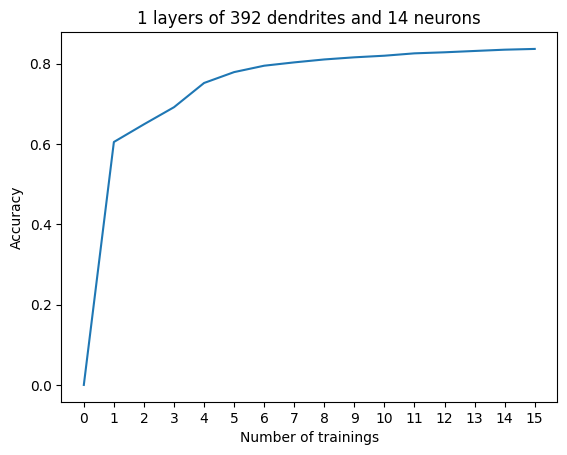

--- NEW MODEL 9 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Checking accuracy on test data
Got 6105 / 10000 with accuracy 61.05%
Row: 1 | 392 | 14 | [0, 0.6105]


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Checking accuracy on test data
Got 6465 / 10000 with accuracy 64.65%
Row: 2 | 392 | 14 | [0, 0.6105, 0.6465]


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Checking accuracy on test data
Got 6570 / 10000 with accuracy 65.70%
Row: 3 | 392 | 14 | [0, 0.6105, 0.6465, 0.657]


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Checking accuracy on test data
Got 6607 / 10000 with accuracy 66.07%
Row: 4 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 6649 / 10000 with accuracy 66.49%
Row: 5 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649]


100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


Checking accuracy on test data
Got 6681 / 10000 with accuracy 66.81%
Row: 6 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649, 0.6681]


100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Checking accuracy on test data
Got 6708 / 10000 with accuracy 67.08%
Row: 7 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649, 0.6681, 0.6708]


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Checking accuracy on test data
Got 6720 / 10000 with accuracy 67.20%
Row: 8 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649, 0.6681, 0.6708, 0.672]


100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


Checking accuracy on test data
Got 6734 / 10000 with accuracy 67.34%
Row: 9 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649, 0.6681, 0.6708, 0.672, 0.6734]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 6741 / 10000 with accuracy 67.41%
Row: 10 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649, 0.6681, 0.6708, 0.672, 0.6734, 0.6741]


100%|██████████| 5/5 [00:08<00:00,  1.80s/it]


Checking accuracy on test data
Got 6762 / 10000 with accuracy 67.62%
Row: 11 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649, 0.6681, 0.6708, 0.672, 0.6734, 0.6741, 0.6762]


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Checking accuracy on test data
Got 6770 / 10000 with accuracy 67.70%
Row: 12 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649, 0.6681, 0.6708, 0.672, 0.6734, 0.6741, 0.6762, 0.677]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 6781 / 10000 with accuracy 67.81%
Row: 13 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649, 0.6681, 0.6708, 0.672, 0.6734, 0.6741, 0.6762, 0.677, 0.6781]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 6790 / 10000 with accuracy 67.90%
Row: 14 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649, 0.6681, 0.6708, 0.672, 0.6734, 0.6741, 0.6762, 0.677, 0.6781, 0.679]


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Checking accuracy on test data
Got 6799 / 10000 with accuracy 67.99%
Row: 15 | 392 | 14 | [0, 0.6105, 0.6465, 0.657, 0.6607, 0.6649, 0.6681, 0.6708, 0.672, 0.6734, 0.6741, 0.6762, 0.677, 0.6781, 0.679, 0.6799]


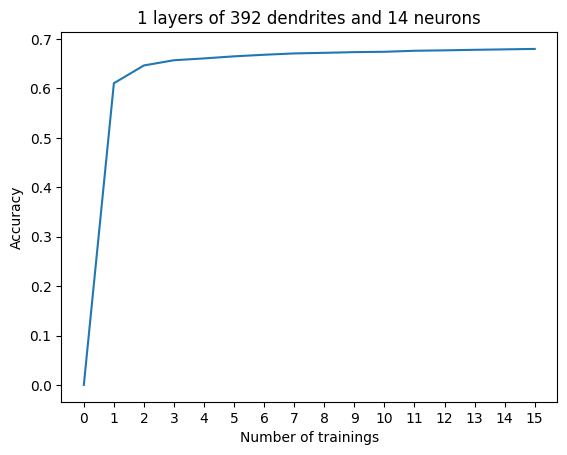

Test 0: [0, 0.6054, 0.7116, 0.7333, 0.7677, 0.7879, 0.7996, 0.8084, 0.8158, 0.8217, 0.826, 0.8308, 0.8335, 0.8357, 0.8382, 0.8407]
Test 1: [0, 0.554, 0.649, 0.6592, 0.7459, 0.7523, 0.7553, 0.7575, 0.7603, 0.8396, 0.8503, 0.8534, 0.8546, 0.8563, 0.8579, 0.86]
Test 2: [0, 0.6241, 0.7667, 0.8743, 0.8965, 0.9085, 0.9158, 0.9214, 0.9257, 0.93, 0.9324, 0.9349, 0.9373, 0.9384, 0.9414, 0.9428]
Test 3: [0, 0.5968, 0.6947, 0.7326, 0.7453, 0.752, 0.7566, 0.7607, 0.763, 0.7659, 0.7673, 0.7684, 0.7694, 0.7714, 0.8499, 0.8615]
Test 4: [0, 0.5685, 0.7306, 0.806, 0.8202, 0.8288, 0.8346, 0.8395, 0.8433, 0.8453, 0.8469, 0.8485, 0.8505, 0.8514, 0.8533, 0.8548]
Test 5: [0, 0.6329, 0.7312, 0.7491, 0.7571, 0.8159, 0.8421, 0.8473, 0.852, 0.8557, 0.8578, 0.8595, 0.8613, 0.8639, 0.8654, 0.8666]
Test 6: [0, 0.6095, 0.7645, 0.795, 0.8124, 0.8205, 0.9009, 0.9165, 0.922, 0.9281, 0.9317, 0.9348, 0.9381, 0.9402, 0.9423, 0.9442]
Test 7: [0, 0.6727, 0.78, 0.8074, 0.8222, 0.8407, 0.9139, 0.9248, 0.9282, 0.931, 0.9346, 

In [21]:
# Factors of 392
# 1, 2, 4, 7, 8, 14, 28, 49, 56, 98, 196, 392.

num_dendritic_inputs = 392
num_neurons = 14
num_dendrite_neuron_layers = 1

num_trials = 10
num_trainings = 15 
data = {}

for trial in range(num_trials):
  print(f"--- NEW MODEL {trial} --- ")
  data[trial] = run_trials(num_dendritic_inputs, num_neurons, num_dendrite_neuron_layers, num_trainings)

# Print data after all runs
for i in range(num_trials):
  print(f"Test {i}: {data[i]}")

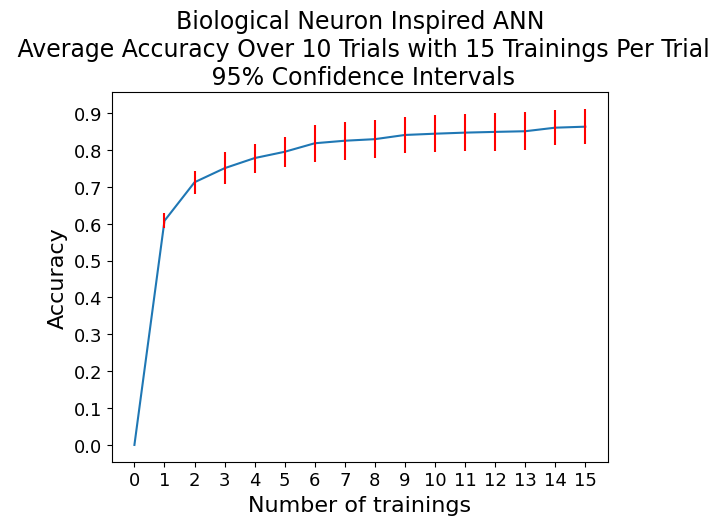

In [22]:
# Convert list of data over tests into a data frame
df = pd.DataFrame(data)

# Set up x axis ticks
x_values = list(range(len(df)))
trial_idx_list = list(range(num_trials))

# List of confidence intervals at each training
ci_values = []

mean_values = df[trial_idx_list].mean(axis=1).tolist()

for _, row in df[trial_idx_list].iterrows():
  mean = row.mean()
  sem = row.sem()
  ci = sem * 1.96  # 95% confidence interval
  ci_values.append(ci)

# Plot styling
plt.title(f"Biological Neuron Inspired ANN\n Average Accuracy Over {num_trials} Trials with {num_trainings} Trainings Per Trial\n 95% Confidence Intervals", fontsize = 17)
plt.xlabel("Number of trainings", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)

plt.xticks(np.arange(0, 16, 1), fontsize = 13)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize = 13)

sns.lineplot(x = x_values, y = mean_values)
plt.errorbar(x = x_values, y = mean_values, yerr=ci_values, linestyle='None', color='red')
plt.show()
